In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
def load_df(url: str) -> pd.DataFrame:
    df = pd.read_parquet(url)

    df["duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
    df["duration_min"] = df.duration.apply(lambda td: td.total_seconds() / 60)

    prepare_for_vectoriser = ["PULocationID", "DOLocationID"]
    df[prepare_for_vectoriser] = df[prepare_for_vectoriser].astype("str")

    return df

In [5]:
# https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
df_train = load_df("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

In [6]:
display(df_train.head())
display(df_train.shape)
df_train.duration_min.std()

# Q1: 19 columns in dataset + 2 added by me
# Q2: duration std ~= 42.59

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration,duration_min
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50,10.833333


(3066766, 21)

42.594351241920904

/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration_min', ylabel='Density'>

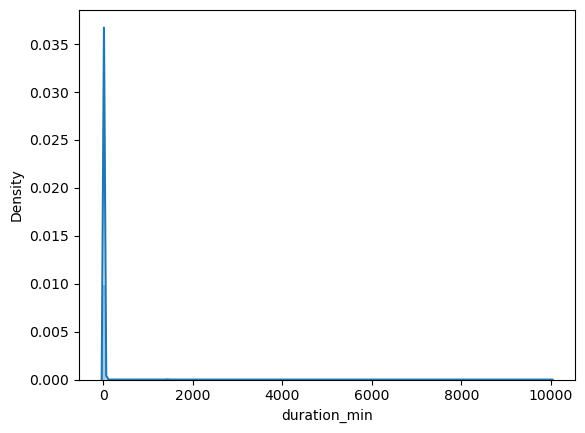

In [8]:
sns.histplot(
    df_train.duration_min, kde=True, stat="density", bins=100, 
    alpha=.4, edgecolor=(1, 1, 1, .4), kde_kws=dict(cut=3),
)

In [9]:
((df_train["duration_min"] >= 1) & (df_train["duration_min"] <= 60)).mean()

0.9812202822125979

In [10]:
# Q3: 98% will be left in dataset after outliers drop

In [11]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df["duration_min"] >= 1) & (df["duration_min"] <= 60)]
    
    return df

In [12]:
df_train = remove_outliers(df_train)

/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration_min', ylabel='Density'>

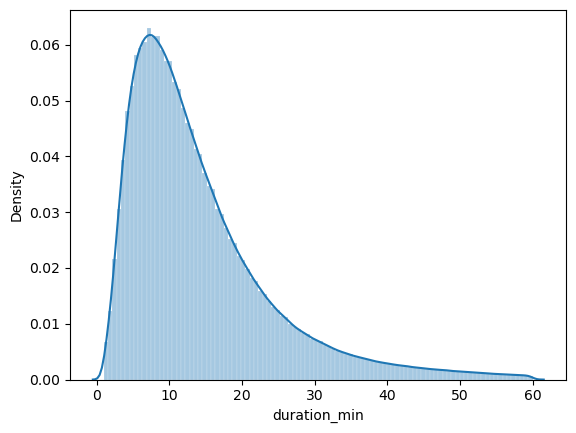

In [13]:
sns.histplot(
    df_train.duration_min, kde=True, stat="density", bins=100, 
    alpha=.4, edgecolor=(1, 1, 1, .4), kde_kws=dict(cut=3),
)

In [14]:
df_val = load_df("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

In [15]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["duration_min"]

train_dict = df_train[categorical + numerical].to_dict(orient="records")
val_dict = df_val[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)


In [16]:
X_train, X_val
# q4: 516 columns

(<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
 	with 9027519 stored elements in Compressed Sparse Row format>,
 <2913955x516 sparse matrix of type '<class 'numpy.float64'>'
 	with 8741853 stored elements in Compressed Sparse Row format>)

In [18]:
target = "duration_min"

y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred_train = lr.predict(X_train)

/tmp/ipykernel_2498/2145754068.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_train, label="prediction")
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2498/2145754068.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-lev

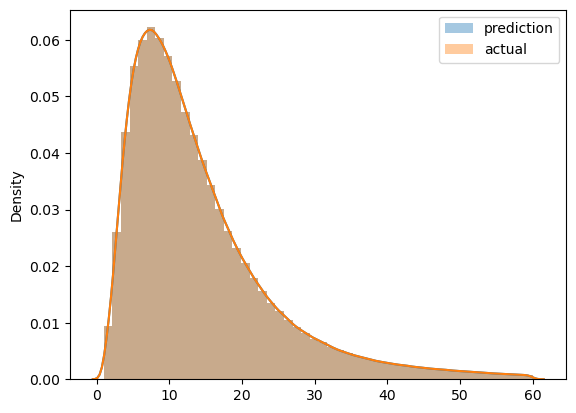

In [26]:
sns.distplot(y_pred_train, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [24]:
mean_squared_error(y_train, y_pred_train, squared=False)

2.080128545809099e-05

In [27]:
y_pred_val = lr.predict(X_val)

In [28]:
mean_squared_error(y_val, y_pred_val, squared=False)

2.582313013311356e-05